# 1. Практическое задание. Обучение полносвязной нейронной сети.

**ФИО**: Солоднёва Екатерина Алексеевна
**Дедлайн**: 09 октября 2020

In [1]:
import numpy as np
import torch
import cv2

from glob import glob
from collections import OrderedDict
from matplotlib import pyplot as plt

from torch import nn
from torch.autograd import Function
from torch.autograd import gradcheck
from torch.optim import Optimizer, Adam
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision import transforms

## 1. Загрузка данных

Если вам требуется работать с каким-нибубь набором данных (dataset), то прежде всего проверьте нет ли его среди встроенных наборов данных https://pytorch.org/vision/stable/datasets.html.

В текущем домашнем задании мы будем работать с набором данных FashionMNIST. Он присутствует в списке встроенных наборов данных, однако мы воспользуемся реализацией только для удобного и быстрого способа скачать наборы данных. Ниже предлагается реализовать собственный класс для считывания, обработки и упаковки данных.

In [2]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



Воспользуемся функцией загрузки данных из репозитория наборов данных.

In [3]:
! ls data/FashionMNIST/raw

t10k-images-idx3-ubyte	   train-images-idx3-ubyte
t10k-images-idx3-ubyte.gz  train-images-idx3-ubyte.gz
t10k-labels-idx1-ubyte	   train-labels-idx1-ubyte
t10k-labels-idx1-ubyte.gz  train-labels-idx1-ubyte.gz


In [4]:
#https://github.com/zalandoresearch/fashion-mnist/blob/master/utils/mnist_reader.py

def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

Для удобства PyTorch предоставляет ряд базовых классов `Dataset, DataLoader`, от которых предлагается отнаследоваться при разработке пользовательских классов. Базовый класс `Dataset` используется для загрузки и обработки данных, класс `DataLoader` используется для управления процессом загрузки данных, позволяет в многопоточном режиме загружать данные и упаковывать их.
Эти вспомогательные классы находятся в модуле `torch.utils.data`. 

При наследовании от класса `torch.utils.data.Dataset` требуется переопределить метод `__len__`, который возвращает количество примеров в наборе данных, а также метод `__getitem__`, который позволяет получить доступ к примеру из набора данных по индексу.

Реализуем класс для FasionMnist.

Элементами датасета должны являться пары '(np.array, int)', массив имеет размерность `(28, 28)`, тип элемента `np.float32`.

In [5]:
import os

class FashionMnist(Dataset):
    def __init__(self, path, train=True, image_transform=None, 
                 label_transform=None):
        if train:
            images, labels = load_mnist(os.path.join(path,"raw"))
        else:
            images, labels = load_mnist(os.path.join(path,"raw"), kind="t10k")

        self.images = images
        self.labels = labels
        self.label_transform = label_transform
        self.image_transform = image_transform
       
    def __len__(self,):
        length = len(self.images)
        return length

    def __getitem__(self, idx):
        img, label = self.images[idx], self.labels[idx]
        if self.label_transform:
          label = self.label_transform(np.array(label))
        if self.image_transform:
          img = self.image_transform(img)
        return img, label

In [6]:
test_dataset = FashionMnist("data/FashionMNIST", train=False)
train_dataset = FashionMnist("data/FashionMNIST")

Визуализируйте случайные элементы набора данных.

In [7]:
def show_images_with_captions(images, captions=None, ncol=None):
    if ncol == None:
      ncol = int(np.sqrt(len(images)))
    nrow = len(images) // ncol
    
    plt.figure(figsize=(9, 9 * nrow // ncol))
    for i in range(len(images)):
        plt.subplot(nrow, ncol, i + 1)
        plt.imshow(images[i].reshape(28, 28), cmap="gray")
        if captions is not None:
            plt.title(captions[i])
        plt.grid(False)
        plt.axis(False)
    plt.show()

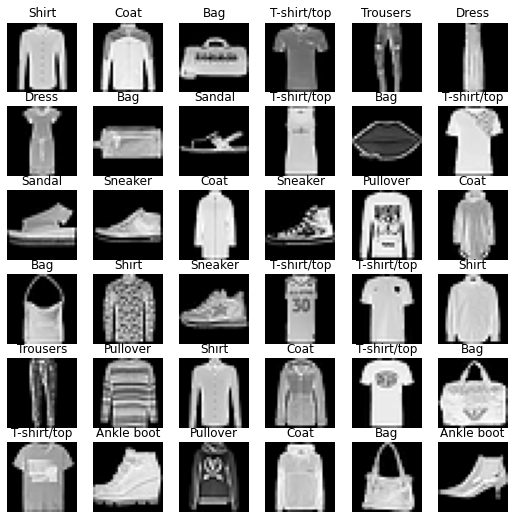

In [8]:
sample_indices = np.random.choice(len(train_dataset), size=36, replace=False)

sample_images = []
sample_captions = []
label_list = ['T-shirt/top', 'Trousers', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

for i in sample_indices:
    image, label = train_dataset[i]
    sample_images.append(image)
    sample_captions.append(label_list[int(label)])

show_images_with_captions(sample_images, sample_captions)

В конструктор `Dataset` можно передать объект `torchvision.transforms`, который позволяет преобразовать исходные данные. Преобразование `torchvision.transforms.ToTensor` позволяет преобразоать данные из типа `PIL Image` и `numpy.float32` в тип `torch.float32`

Реализуйте собственную поддержку преобразований в `FashionMnist`. Проверьте, что приведение типов работает корректно. 

In [9]:
class ToTensor:
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        return torch.from_numpy(sample)

In [10]:
transform = ToTensor()

test_dataset = FashionMnist("data/FashionMNIST", 
                            train=False, 
                            image_transform=transform, 
                            label_transform=transform
                            )
train_dataset = FashionMnist("data/FashionMNIST",
                             image_transform=transform, 
                             label_transform=transform
                             )

In [11]:
print(f"The type of the data is {type(test_dataset[0][0])}")

The type of the data is <class 'torch.Tensor'>


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:172.)
  """


Элементы набора данных могут быть объединены в пакеты (batch) явно и неявно. Если данные могут быть сконкатенированы или обЪединены каким-нибудь тривиальным способом, то можно не передавать никаких дополнительных парамертов в `torch.utils.data.Dataloader`.

In [12]:
test_dataloader = DataLoader(test_dataset, batch_size=15, num_workers=2, shuffle=True)
batch = next(iter(test_dataloader))

In [13]:
print(f"The length of the batch is {len(batch)}")
print(f"The shape of the batch[0] is {batch[0].shape}")

The length of the batch is 2
The shape of the batch[0] is torch.Size([15, 784])


Однако, если наша структура данных не позволяет нам использовать объединение по умолчанию, то можно написать собственную функцию, которая будет пакетировать данные. 

Реализуйте функцию, преобразующую последовательность элементов массива в пакет (batch).

In [14]:
def collate(batch):
    images = []
    labels = []

    for img, lbl in batch:
      images.append(img/250.)
      labels.append(lbl)
    imgs = torch.stack(images)
    lbls = torch.stack(labels)
    return imgs, lbls

Убедитесть, что все работает корректно. 

In [15]:
test_dataloader = DataLoader(test_dataset, batch_size=15, num_workers=2, 
                             shuffle=True, collate_fn=collate)
train_dataloader = DataLoader(train_dataset, batch_size=15, num_workers=2,
                              shuffle=True, collate_fn=collate)
batch = next(iter(test_dataloader))

In [16]:
print(f"The length of the batch is {len(batch)}")
print(f"The shape of the batch[0] is {batch[0].shape}")

The length of the batch is 2
The shape of the batch[0] is torch.Size([15, 784])


## 2. Реализация модулей нейронной сети (15 баллов)

В этом разделе мы полностью реализуем модули для полносвязанной сети. 

Для начала нам понадобится реализовать прямой и обратный проход через слои. 

Наши слои будут соответствовать следующему интерфейсу (на примере "тождественного" слоя):

Сначала, мы реализуем функцию и её градиент. 

In [17]:
class IdentityFunction(Function):
    """
    We can implement our own custom autograd Functions by subclassing
    torch.autograd.Function and implementing the forward and backward passes
    which operate on Tensors.
    """
    @staticmethod
    def forward(ctx, input):
        """
        In the forward pass we receive a Tensor containing the input and return
        a Tensor containing the output. ctx is a context object that can be used
        to stash information for backward computation. You can cache arbitrary
        objects for use in the backward pass using the ctx.save_for_backward method.
        """
        ctx.save_for_backward(input)
        return input

    @staticmethod
    def backward(ctx, grad_output):
        val, = ctx.saved_tensors
        grad_output *= torch.ones_like(val)
        return grad_output

Разработанную функцию обернем классом `IdentityLayer`, все слои в `PyTorch` должны быть наследниками базового класса `nn.Module()`


In [18]:
class IdentityLayer(nn.Module):
    def __init__(self):
        # An identity layer does nothing
        super().__init__()
        self.identity = IdentityFunction.apply
    
    def forward(self, inp):
        # An identity layer just returns whatever it gets as input.
        return self.identity(inp)


### 2.1 Функция активации ReLU
Для начала реализуем функцию активации, слой нелинейности `ReLU(x) = max(x, 0)`. Параметров у слоя нет. Метод `forward` должен вернуть результат поэлементного применения `ReLU` к входному массиву, метод `backward` - градиент функции потерь по входу слоя. В нуле будем считать производную равной 0. Обратите внимание, что при обратном проходе могут понадобиться величины, посчитанные во время прямого прохода, поэтому их стоит сохранить в `ctx`.

In [19]:
class ReLUFunction(Function):
    @staticmethod
    def forward(ctx, input):
        input_plus = torch.where(input>0, input, torch.zeros_like(input))
        ctx.save_for_backward(input_plus)
        return input_plus

    @staticmethod
    def backward(ctx, grad_output):
        val, = ctx.saved_tensors
        grad_output *= torch.where(val>0, torch.ones_like(val), torch.zeros_like(val))
        return grad_output


In [20]:
class ReLU(nn.Module):
    def __init__(self):
        super().__init__()
        self.relu = ReLUFunction.apply
        #return

    
    def forward(self, input):
        return self.relu(input)

Не забываем после реализации функции проверить градиент, используя функцию `gradcheck`.

In [21]:
relu = ReLUFunction.apply
x = torch.randn(3, requires_grad = True).double()

assert gradcheck(relu, x)

In [22]:
torch_relu = nn.ReLU()
our_relu = ReLU()#Function.apply

assert torch.norm(torch_relu(x.float()) - our_relu(x)) < 1e-5

### 2.2 Линейный слой (linear, fully-connected)
Далее реализуем полносвязный слой без нелинейности. У слоя два набора параметра: матрица весов (weights) и вектор смещения (bias).

In [23]:
class LinearFunction(Function):
    @staticmethod
    def forward(ctx, inp, weights, bias):
        output = inp @ weights.T + bias
        ctx.save_for_backward(inp, weights, bias)
        return output
    @staticmethod
    def backward(ctx, grad_output):
        inp, weight, bias = ctx.saved_tensors
        grad_input = grad_output @ weight
        grad_weight = grad_output.T @ inp
        grad_bias = grad_output.sum(0).view(1, -1)
        return grad_input, grad_weight, grad_bias

In [24]:
class Linear(nn.Module):
    def __init__(self, input_units, output_units):
        super().__init__()
        # initialize weights with small random numbers from normal distribution
        self.weight = nn.Parameter( 
            torch.randn(output_units, input_units)*1e-3
            )
        self.bias = nn.Parameter(
            torch.zeros(output_units)
        )
        self.Linear = LinearFunction.apply
        
    def forward(self,inp):
      return self.Linear(inp, self.weight, self.bias.view(1, -1))


Проверим градиент, а также сравним с работой нашего модуля с имплементированным в `PyTorch`. 

Проверка градиента:

In [25]:
linfun = LinearFunction.apply
x = torch.randn(3, 3, requires_grad = True).double()
w = torch.randn(5, 3, requires_grad = True).double() * 1e-3
b = torch.randn(5, requires_grad = True).double() * 1e-3
assert gradcheck(linfun, (x, w, b))

Сравнение с `PyTorch`. 

In [26]:
torch_linear = nn.Linear(3, 5)
our_linear = Linear(3, 5)
weight = torch.randn(5, 3, requires_grad = True).double() * 1e-3
bias = torch.randn(5, requires_grad = True).double() * 1e-3

state_dict = OrderedDict([("weight", weight), ("bias", bias)])
torch_linear.load_state_dict(state_dict)
our_linear.load_state_dict(state_dict)

assert torch.norm(torch_linear.forward(x.float()) - our_linear(x.float())) < 1e-5

### 2.3 LogSoftmax (Log + Softmax)

Для решения задачи многоклассовой классификации обычно используют `softmax` в качестве нелинейности на последнем слое, чтобы получить "оценку" вероятности классов для каждого объекта:$$\hat y = softmax(x)  = \bigl \{\frac {exp(x_i)}{\sum_j exp(x_j)} \bigr \}_{i=1}^K, \quad K - \text{число классов}$$В этом случае удобно оптимизировать логарифм правдоподобия:$$L(y, \hat y) = -\sum_{i=1}^K y_i \log \hat y_i \rightarrow \min,$$где $y_i=1$, если объект принадлежит $i$-му классу, и 0 иначе. Записанная в таком виде, эта функция потерь совпадает с выражением для кросс-энтропии. Очевидно, что ее также можно переписать через индексацию, если через $y_i$ обозначить класс данного объекта:$$L(y, \hat y) = - \log \hat y_{y_i} \rightarrow \min$$В таком виде ее удобно реализовывать.

Реализуйте слой `LogSoftmax` (без параметров). Метод `forward` должен вычислять логарифм от `softmax`, а метод `backward` - пропускать градиенты. В общем случае в промежуточных вычислениях `backward` получится трехмерный тензор, однако для нашей конкретной функции потерь все вычисления можно реализовать в матричном виде. Поэтому мы будем предполагать, что аргумент `grad_output` - это матрица, у которой в каждой строке только одно ненулевое значение (не обязательно единица).

Комментарий: разобраться `Log-Sum-Exp trick`

In [27]:
class LogSoftmaxFunction(Function):
    @staticmethod
    def forward(ctx, inp):
      '''
      x_max = torch.max(inp)
      S = torch.exp(inp - x_max).sum()
      logsumexp = torch.log(S)
      ctx.save_for_backward(inp)
      return inp - x_max - logsumexp
      '''
      logsmexp = torch.logsumexp(inp, dim=1)
      logsm = inp - logsmexp.view(inp.shape[0], -1)
      ctx.save_for_backward(logsm)

      return logsm
    
    @staticmethod        
    def backward(ctx, grad_output):
      logsm, = ctx.saved_tensors
      '''
      S = torch.exp(inp).sum()
      x = torch.exp(inp) * torch.ones(inp.shape[1], inp.shape[0])
      J = torch.eye(inp.shape[0]) -  x / S
      grad_output = J.T @ grad_output
      '''
      sumexp = torch.exp(logsm)
      x = torch.sum(grad_output, dim=1).view(sumexp.shape[0],-1) * sumexp
      grad_output -= x                  # ~grad_output * (E - x)
      return grad_output

In [28]:
class LogSoftmax(nn.Module):
    def __init__(self):
        super().__init__()
        self.LogSoftmax = LogSoftmaxFunction.apply

    def forward(self, input):
        return self.LogSoftmax(input)

Проверка градиентов.

In [29]:
x = torch.randn(5, 10, requires_grad = True).double()

#x = torch.tensor([1,0,0]).double()
#x.requires_grad_()
logsoft = LogSoftmaxFunction.apply
assert gradcheck(logsoft, x)

In [33]:
torch_LSm = nn.LogSoftmax()
our_LSm = LogSoftmax()#Function.apply

assert torch.norm(torch_LSm(x.float()) - our_LSm(x)) < 1e-5

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.


### 2.4 Dropout
Реализуйте слой Dropout.

In [34]:
class DropoutFunction(Function):
    @staticmethod
    def forward(ctx, inp, p):

      mask = torch.rand(inp.shape) < p # torch.bernoulli(torch.ones_like(inp) * (1 - p))
      if not mask.is_cuda and inp.is_cuda:   
        mask = mask.to('cuda')
      inp_w_zeros = inp * mask 
      ctx.save_for_backward(mask)
      return inp_w_zeros
        
    @staticmethod
    def backward(ctx, grad_output):
      mask, = ctx.saved_tensors
      return grad_output * mask, None
        

In [35]:
class Dropout(nn.Module):
    def __init__(self, p=0.5):
        super().__init__()
        self.Dropout = DropoutFunction.apply
        self.p = p
        
    def forward(self, input):
        if self.training:
          return self.Dropout(input, self.p)
        else:
          return self.Dropout(input, self.p) * (1-self.p) 

### 2.5 CrossEntropy

При решении задачи многоклассовой классификации мы будет использовать в качестве функции потерь кроссэнтропию. Реализуйте функцию потерь. В разделе 2.3 приведены полезные формулы.

In [36]:
class CrossEntropyFunction(Function):
    @staticmethod
    def forward(ctx, activations, target):
      ctx.save_for_backward(activations, target)
      elems = torch.gather(activations, 1, target.to(torch.int64).unsqueeze(-1))
      return -sum(elems) / target.shape[0]

    @staticmethod
    def backward(ctx, grad_output):
      act, tar = ctx.saved_tensors
      '''
      mask = torch.zeros_like(act)
      for i in range(tar.shape[0]):
        mask[i][tar[i]] = 1
      '''
      tar = tar.to(torch.int64)
      #print('mask_:', mask_.is_cuda)
      #print('pairs:', pairs.is_cuda)
      tar_idx = torch.arange(tar.shape[0])
      if not tar_idx.is_cuda and tar.is_cuda:
        tar_idx = tar_idx.to('cuda')
      pairs = torch.stack([tar_idx, tar]).T
      mask_ = torch.zeros_like(act)
      mask_[pairs[:, 0], pairs[:, 1]] = -1/tar.shape[0]
      
      return grad_output * mask_, None

class CrossEntropy(nn.Module):
    def __init__(self, ):
        super().__init__()
        self.CrossEntropy = CrossEntropyFunction.apply

    def forward(self, activations, target):
        return self.CrossEntropy(activations, target)

Проверка градиентов.

In [37]:
x = torch.randn(3, 2, requires_grad = True).double()
t = torch.randint(2, (3,))
cross_ent = CrossEntropyFunction.apply
assert gradcheck(cross_ent, (x, t))

In [38]:
torch_loss = nn.CrossEntropyLoss()
our_loss = CrossEntropy()
x = torch.randn(3, 2, requires_grad = True).float()
lsm = LogSoftmaxFunction.apply
x_pr = lsm(x)
assert torch.norm(torch_loss(x, t) - our_loss(x_pr, t)) < 1e-5

## 3. Сборка и обучение нейронной сети (5 балла)

Реализуйте произвольную нейросеть, состоящую из ваших блоков. Она должна состоять из нескольких полносвязанных слоев.

In [39]:
class Network(nn.Module):
    def __init__(self, input_size=28*28, hidden_layers_size=32, num_layers=2,
                 num_classes=10):
        super().__init__()
        net = nn.Sequential(Linear(input_size, hidden_layers_size),
                            ReLU())
        for i in range(num_layers):
          net.append(Linear(hidden_layers_size, hidden_layers_size))
          net.append(ReLU())
          net.append(Dropout())
        net.append(Linear(hidden_layers_size, num_classes))
        net.append(LogSoftmax())
        self.net = net
    def forward(self, inp):
        inp = inp.float()
        out = self.net(inp)
        return out
    def predict(self, inp):
        inp = inp.float()#double()
        out = self.net(inp)
        _, pred = torch.max(out.data, 1)
        return pred


Ниже приведены функции, реализующие обучение нейронной сети. В данном задании их предлагается просто переиспользовать. 

In [40]:
class EmptyContext:
    def __enter__(self):
        pass
    
    def __exit__(self, *args):
        pass

In [41]:
# accuracy metric for our classififcation
def accuracy(model_labels, labels):
  return torch.mean((model_labels == labels).float())

In [42]:
def perform_epoch(model, loader, criterion, 
                optimizer=None, device=None):
    is_train = optimizer is not None
    model = model.to(device)
    if is_train:  
        model.train()
    else:
        model.eval()

    total_loss = 0
    total_acc = 0
    total_n = 0
    with EmptyContext() if is_train else torch.no_grad():
        for batch_data, batch_labels in loader:
            batch_data = batch_data.to(device)
            batch_labels = batch_labels.to(device)          
            model_labels = model(batch_data)
            #print(model_labels)
            #print('---------------------')
            #print(batch_labels)
            model_prediction = model.predict(batch_data)
            new_loss = criterion(model_labels, batch_labels) ######
            if is_train:
              optimizer.zero_grad()
              new_loss.backward()
              optimizer.step() 

            one_batch_loss = float(criterion(model_labels, batch_labels))
            one_batch_acc = accuracy(model_prediction, batch_labels)
            
            total_loss += one_batch_loss
            total_acc += one_batch_acc
            total_n += 1 
    return (total_loss / total_n, total_acc / total_n) 

Теперь обучим нашу нейронную сеть. В данном разделе будем использовать оптимизатор `Adam` с параметрами по умолчанию.

In [43]:
Batch_Size = 32
test_dataloader = DataLoader(test_dataset, batch_size=Batch_Size, num_workers=2, 
                             shuffle=True, collate_fn=collate)
train_dataloader = DataLoader(train_dataset, batch_size=Batch_Size, num_workers=2,
                              shuffle=True, collate_fn=collate)

In [44]:
model     = Network()
optimizer = Adam(model.parameters(), lr=1e-3)
criterion = CrossEntropy() #для проверки logsoftmax

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

for epoch in range(10):
    loss, acc = perform_epoch(model, 
                              train_dataloader,
                              criterion, 
                              optimizer=optimizer, device=device)
    print(f"Epoch - {epoch} : loss {loss}, accuracy {acc}")
    print(f"Current learning rate: {optimizer.param_groups[0]['lr']}")

In [ ]:
print(f"Epoch - {epoch} : loss {loss}, accuracy {acc}")
print(f"Current learning rate: {optimizer.param_groups[0]['lr']}")

Дальше:
- Проведите эксперименты с числом слоев. 
- Постройте графики зависимости качества модели на тренировочной и тестовой выборках от числа слоев. Для получения статистически значимых результатов повторите эксперименты несколько раз.
- Сделайте выводы. 

В силу ограничений Google Colab проведём эксперименты с малым числом слоёв.

In [51]:
n_layers = [1, 2]
acc_dict = {str(i): [0 for j in range(10)] for i in n_layers}
loss_dict = {str(i): [0 for j in range(10)] for i in n_layers}

In [52]:
num_iter = 3
for iter in range(num_iter): 
  for i in n_layers:
    model     = Network(num_layers = i)
    optimizer = Adam(model.parameters(), lr=1e-3)
    criterion = CrossEntropy() 

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.to(device)

    for epoch in range(5):
        loss, acc = perform_epoch(model, 
                                  train_dataloader,
                                  criterion, 
                                  optimizer=optimizer, device=device)
        loss_dict[str(i)][epoch]+= loss / num_iter
        acc_dict[str(i)][epoch] += acc / num_iter
        print(f"Epoch - {epoch} : loss {loss}, accuracy {acc}")
        print(f"Current learning rate: {optimizer.param_groups[0]['lr']}")

Epoch - 0 : loss 1.2847778419176739, accuracy 0.46773335337638855
Current learning rate: 0.001
Epoch - 1 : loss 1.02271147925059, accuracy 0.6092000007629395
Current learning rate: 0.001
Epoch - 2 : loss 0.9390817052205404, accuracy 0.6534667015075684
Current learning rate: 0.001
Epoch - 3 : loss 0.8793951173782348, accuracy 0.6810333132743835
Current learning rate: 0.001
Epoch - 4 : loss 0.8276822253068288, accuracy 0.7043499946594238
Current learning rate: 0.001
Epoch - 0 : loss 1.571473591041565, accuracy 0.34815001487731934
Current learning rate: 0.001
Epoch - 1 : loss 1.3318565461794536, accuracy 0.4568333327770233
Current learning rate: 0.001
Epoch - 2 : loss 1.2288361003557842, accuracy 0.4972499907016754
Current learning rate: 0.001
Epoch - 3 : loss 1.1570212262153625, accuracy 0.5303500294685364
Current learning rate: 0.001
Epoch - 4 : loss 1.1087943419774373, accuracy 0.5645166635513306
Current learning rate: 0.001
Epoch - 0 : loss 1.390340077273051, accuracy 0.41253334283828

In [68]:
acc_1 = [acc_dict['1'][i].item() for i in range(5)]
acc_2 = [acc_dict['2'][i].item() for i in range(5)]

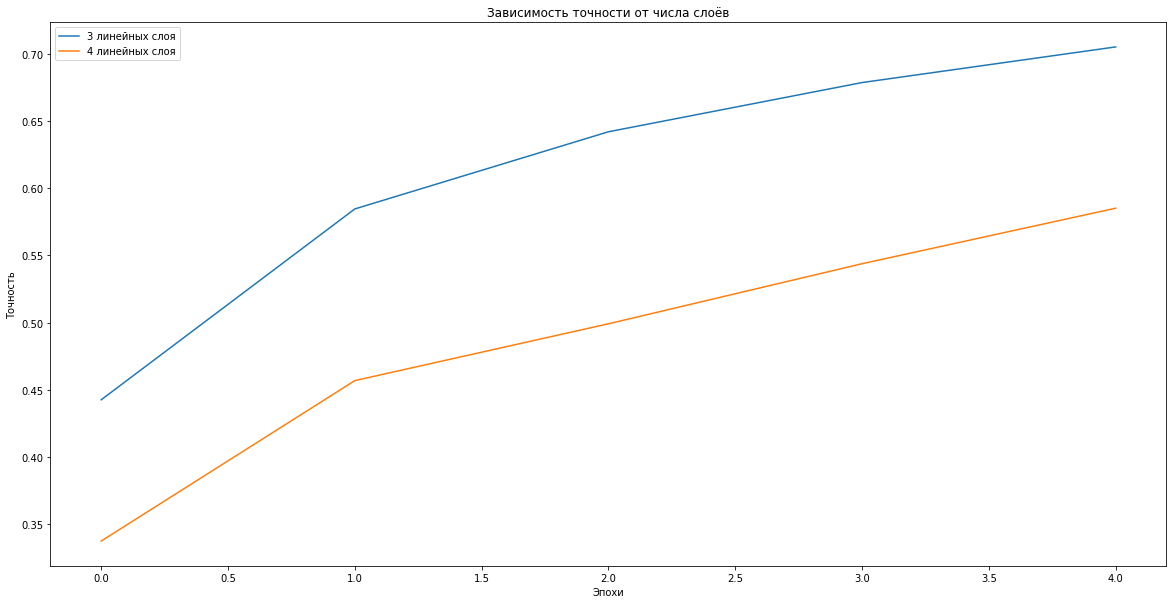

In [71]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20,10)


x = np.arange(5)
fig, ax = plt.subplots()  # Create a figure and an axes.
ax.plot(x, acc_1 , label='3 линейных слоя')  # Plot some data on the axes.
ax.plot(x, acc_2 , label='4 линейных слоя')  # Plot some data on the axes.

ax.set_xlabel('Эпохи')  # Add an x-label to the axes.
ax.set_ylabel('Точность')  # Add a y-label to the axes.
ax.set_title("Зависимость точности от числа слоёв")  # Add a title to the axes.
ax.legend()  # )



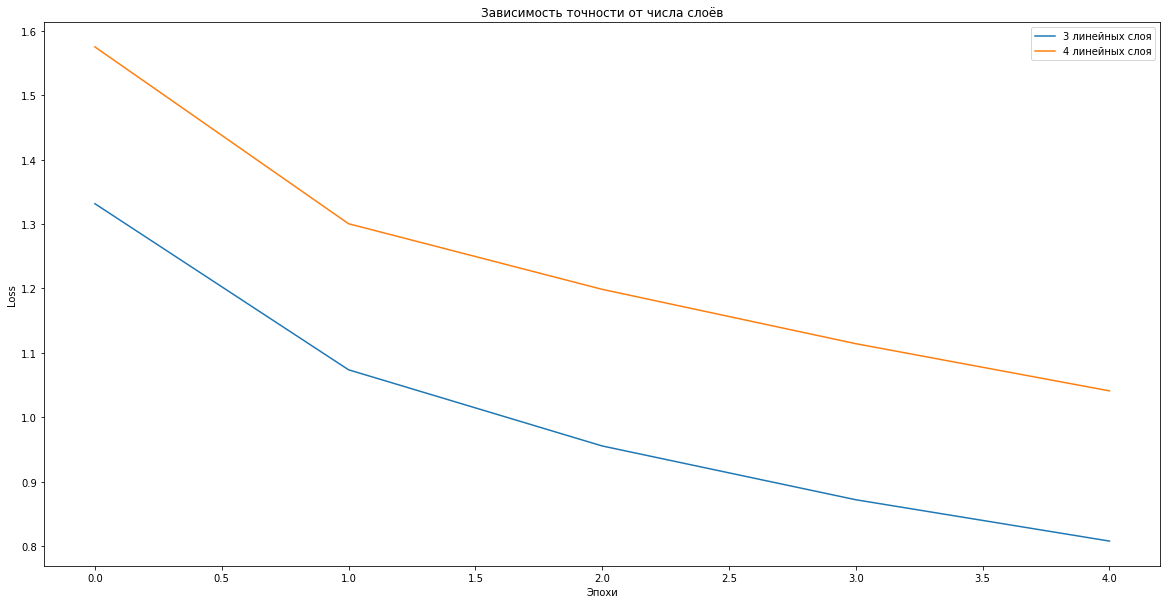

In [76]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20,10)


x = np.arange(5)
fig, ax = plt.subplots()  # Create a figure and an axes.
ax.plot(x, loss_dict['1'][:5] , label='3 линейных слоя')  # Plot some data on the axes.
ax.plot(x, loss_dict['2'][:5] , label='4 линейных слоя')  # Plot some data on the axes.

ax.set_xlabel('Эпохи')  # Add an x-label to the axes.
ax.set_ylabel('Loss')  # Add a y-label to the axes.
ax.set_title("Зависимость точности от числа слоёв")  # Add a title to the axes.
ax.legend()  # )



Получаем, что более простая сеть (состоящая из трёх линейных слоёв) лучше справляется с задачей.

## 4. Бонусная часть.

### 4.1 Реализация метода оптимизации (3 + 3 балла).
Реализуйте сами метод оптимизации  для рассмотренной выше архитектуры. Вы можете выбрать произвольный метод от градиентного спуска до современных вариантов. Продемонстрируйте правильную работу метода оптимизации, сравните его работы с Adam. 

**Дополнительные баллы** вы получите, если метод будет уникален среди сдавших задание. 

In [ ]:
class SotaOptimizer(Optimizer):
    def __init__(self, params, lr=1e-3):
        defaults = dict(lr=lr)
        super(SotaOptimizer, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(SotaOptimizer, self).__setstate__(state)

    @torch.no_grad()
    def step(self,):

        for group in self.param_groups:
            lr = group['lr']
            for p in group['params']:
                if p.grad is not None:
                    p.data.add_(-lr*p.grad)

### 4.2 Реализация современной функции активации (2 + 2 балла).
Реализуйте одну из активаций, предложенных на лекции или в статье. Например, `Hardswish`. Сравните сеть с вашей активацией и с `ReLU`. 

**Дополнительные баллы** вы получите, если функция будет уникальна среди сдавших задание. 